In [95]:
# Here we import basic libraries for graph data handling and visualization
import torch
import torch.nn as nn
from torch_geometric.datasets import KarateClub  # This is the famous Karate Club dataset
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from sklearn.manifold import TSNE

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##### What is KarateClub? 
It is a social NETWORK representing the social relationships among 34 individuals. 

As we previously learnt from the theories of Graph Neural Network (GNN), the key concepy that could be applied here is the message update -- from one person to another 

##### Our Task Here: 
Detect which social group does a member belong to

In [97]:
# Before all, we have to know what is in the dataset and what do they mean
dataset = KarateClub()
data = dataset[0]  # Get the first graph object, there is only one graph in this dataset

# First think about what do we have to know in a GNN
# Nodes (here are individuals), node features, edges, edge features, social groups...
print(f'Number of nodes: {data.num_nodes}')  # Number of nodes
print(f'Number of edges: {data.num_edges}')  # Number of edges
print(f'Node feature dimension: {data.num_node_features}')  # Dimension of node features -- 34 individuals with 34 features each with one-hot encoding
print(f'Edge feature dimension: {data.num_edge_features}')  # Dimension of edge features --  here there is no edge features
print(f'Number of classes: {dataset.num_classes}')  # Number of classes (social groups)

Number of nodes: 34
Number of edges: 156
Node feature dimension: 34
Edge feature dimension: 0
Number of classes: 4


Above are the basic information in KarateClub, now we are going to look for something crucial in decding how to find which faction a member belongs to exactly

1. What does Average Node Degree do? 
    Here it mean a club member and the average connections that he/she has -- between 4 to 5 members. High average node degree indicates a strong/frequent social connection while lower ones represents weaker or fewer relationships.

2. What are the training nodes?
    Here the training nodes are people who we already know which faction they beblong to. With this we can design further GNN to find else. 
    
3. Edges here are undirected
    All the connections are mutual, e.g. When A is connceted with B, B is automatically connected with A, and there is no specific direction in this edge. 

In [98]:
# Now we take look at other data
print(f'Average node degree: {data.num_edges / data.num_nodes:.4f}')  # Average node degree
print(f'Number of training nodes: {data.train_mask.sum()}')  # Number of training nodes
print(f'Traning node label rate: {data.train_mask.sum() / data.num_nodes:.4f}')  # Training node label rate
print(f'Has isolated nodes: {data.has_isolated_nodes()}')  # Check for isolated nodes
print(f'Has self-loops: {data.has_self_loops()}')  # Check for self-loops
print(f'Is undirected: {data.is_undirected()}')  # Check if the graph is undirected

Average node degree: 4.5882
Number of training nodes: 4
Traning node label rate: 0.1176
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [99]:
# egde_index tells us which nodes are connected
edge_index = data.edge_index
print(f'Edge index:\n{edge_index.t()}') # Print edge index in (source, target) format

Edge index:
tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2]

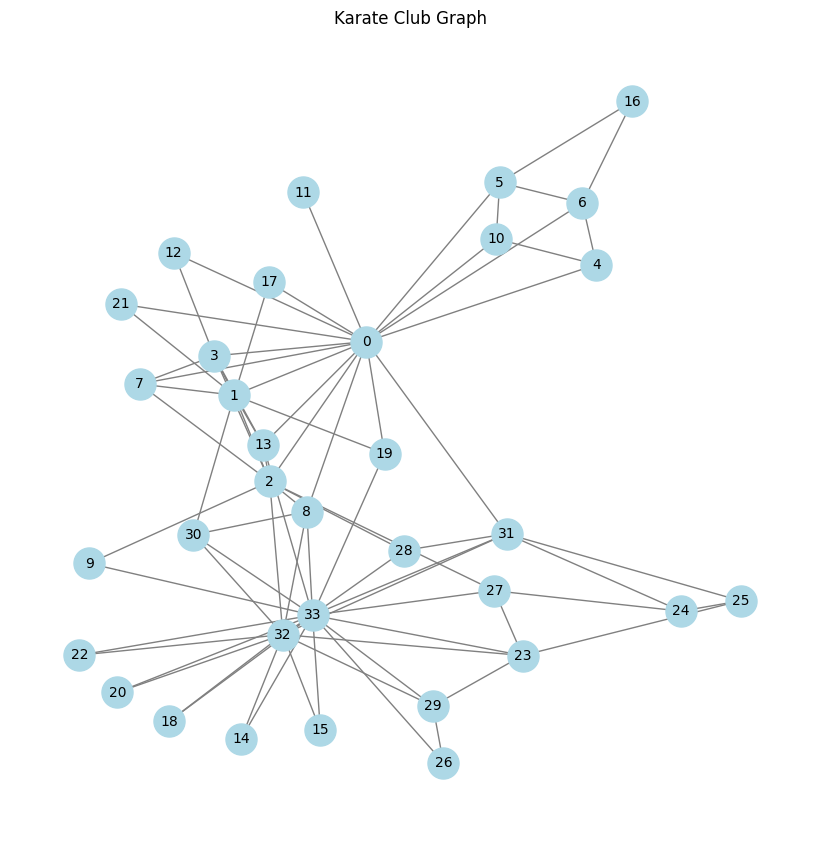

In [100]:
# Here we will visualize the graph
G = to_networkx(data, to_undirected=True)  # convert data to networkx graph
visial_pos = nx.spring_layout(G, seed=42)  # For consistent layout
plt.figure(figsize=(8, 8))
# networkx database can draw the function, here we customize it. 
# On the graph we dont know the division of faction yet. 
nx.draw(G, pos=visial_pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
plt.title('Karate Club Graph')
plt.show()

After the above data processing, we will now moving on to the implementation of GNN

First, we are going to transform the local representation (edge_index here) into the form of distributed vector through a embedding matrix $E$. Here the initial adjacency matrix $A$ in the form of $34\times34$ is transformed, thourgh a $34\times4$ **Learnable Weight Matrix** 
$$r=EI_\omega$$
Then, it comes to the key part of **Message Passing**. Since we aim to use Graph Convolutional Network (GCN), the aggregation here is normalization. By this part, the next 'individual' listened, and update his/her own status. 
$$R_t=\cup_kAM_t^k$$



In [101]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN,self).__init__()
        torch.manual_seed(12345)

        # Layer 1: Input 34 features, output 4 features
        # Here we compress the information to find the patterns
        self.conv1 = GCNConv(dataset.num_node_features,4)  # 34 features compressed to 4

        # Layer 2: Input 4 -> output 4
        self.conv2 = GCNConv(4,4)

        # Layer 3: hidden space (4) -> number of classes/factions
        self.conv3 = GCNConv(4,dataset.num_classes)

        # Classification layer
        # It is going to map the 'individual' into one of the factions
        self.classifier = nn.Linear(2,dataset.num_classes)
    
    # Here we design the 'message passing' function
    def forward(self,x,edge_index):
        # Layer 1 passing
        h = self.conv1(x,edge_index)
        h = h.tanh()    # Activation function (Non-linearity)

        # Layer 2 passing
        h = self.conv2(h,edge_index)
        h = h.tanh()

        # Layer 3 passing
        h = self.conv3(h,edge_index)

        # Final Output
        return h, h

Now we already define the 3_layer simple GCN, we will work on the 'experiment' now -- embedding the karateclub network

In [102]:
# Let's see the model structure
model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 4)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [103]:
criterion = nn.CrossEntropyLoss()  # Define the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define the optimizer -- Gradient Descent with learning rate 0.01

def train(data):
    optimizer.zero_grad()  # Clear gradients
    out,h = model(data.x, data.edge_index)  # This is the 'way forward' message passing

    # Reminder: Why transform 34 into 4?
    # Becasue we will only train 'individuals' with known faction
    loss = criterion(out[data.train_mask],data.y[data.train_mask])
    loss.backward()  # Backpropagation -- Derive gradients
    optimizer.step()  # Update the weights

    return loss, h

# Now we will run the experiment for 401 epochs
for epoch in range(401): 
    loss, h = train(data)
    if epoch % 50 ==0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 1.3807
Epoch 50, Loss: 0.4320
Epoch 100, Loss: 0.0979
Epoch 150, Loss: 0.0483
Epoch 200, Loss: 0.0304
Epoch 250, Loss: 0.0213
Epoch 300, Loss: 0.0160
Epoch 350, Loss: 0.0125
Epoch 400, Loss: 0.0101


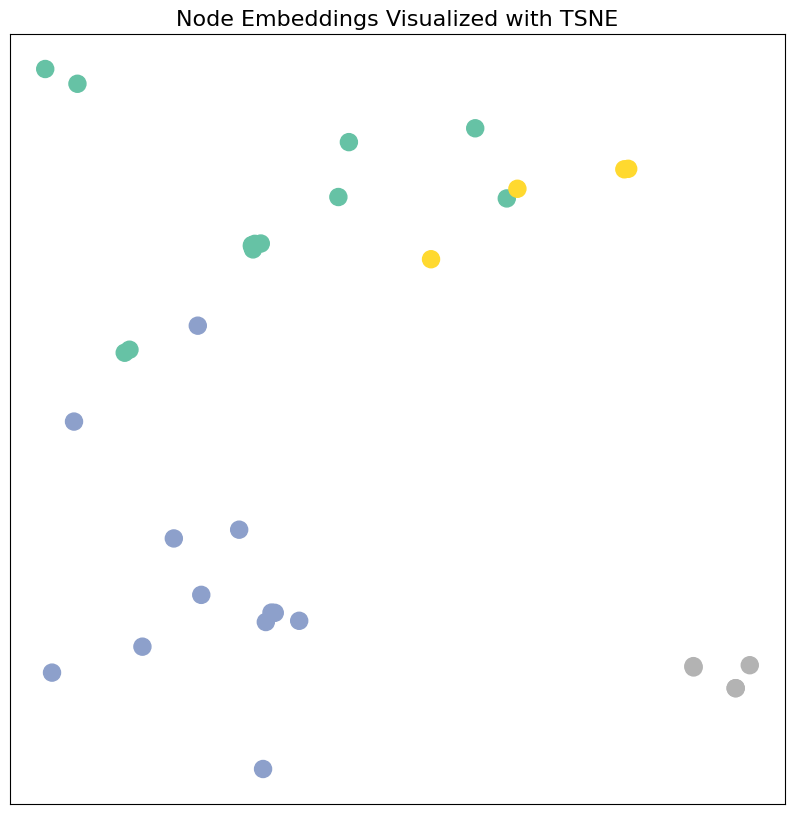

In [104]:
# Finally, we will visualize the embeddings

# Here we define the visualization function
def visualize(h,color):
    z =  TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.title("Node Embeddings Visualized with TSNE", fontsize=16)
    plt.scatter(z[:,0],z[:,1],s=150,c=color,cmap="Set2")
    plt.show()

visualize(h, data.y)  # Visualize the hidden embeddings with true labels
